In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
import sys
sys.path.append('../../') #takes us to the directory named foreground_functions that houses the
#foreground_function.py and the w3j.npy files

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize
import emcee
import corner

Populating the interactive namespace from numpy and matplotlib


In [8]:
%lprun -f ff.auto1x1_synch ff.auto1x1_synch(ells, freqs, params_s)

# Foreground parameters

In [3]:
#the parameters chosen here (except gamma) are from the BICEP 2018 paper. The alphas differ by addition of 2, as we've
#calculated the C_ells, while the BICEP paper models the D_ells. The amplitudes also have had to be scaled to pivot
#frequency of 95 GHz so differ by a factor
A_s_BICEP = 1.0 #micro K^2
A_d_BICEP = 4.6 #micro K^2
alpha_s_BICEP = -0.6
alpha_d_BICEP = -0.4


alpha_s = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_s = -3.1
gamma_s = -2.6 ## is the SO value for this
A_s = A_s_BICEP * (ff.scale_synch(95e9, beta_s)/ff.scale_synch(23e9, beta_s))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_s = A_s[0] #make it stop being an array

alpha_d = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_d = 1.6
gamma_d = -3.0 ## chosen at random
A_d = A_d_BICEP * (ff.scale_synch(95e9, beta_d)/ff.scale_synch(353e9, beta_d))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_d = A_d[0] #make it stop being an array



params_s = [A_s, alpha_s, beta_s, gamma_s]
params_d = [A_d, alpha_d, beta_d, gamma_d] 
params_fg = params_s + params_d

nside=128
ells = np.arange(384)
freqs = np.linspace(30,300,20)*1.e9 
freqs_SO = np.array([27, 39, 93, 145, 225, 280])*1e9

In [4]:
print(A_s, A_d)

2.2573626192909638e-07 6.333974970372965e-07


# CMB data

In [5]:
#the D_ells of the CMB with r=0.01
camb_lens_r1 = loadtxt('../../power_spectra/camb_lens_r1.dat').T
camb_lens_nobb = loadtxt('../../power_spectra/camb_lens_nobb.dat').T
primo_bb = camb_lens_r1[3]
lens_bb = camb_lens_nobb[3]
r = 0.01
bb_001 = (r * primo_bb + lens_bb)[:384]

In [6]:
params_in = params_fg + [r]

In [7]:
def cmb(ells, r):
    return r*primo_bb[:len(ells)] + lens_bb[:len(ells)]

In [8]:
def cosmic_var(model):
    var = np.zeros((len(freqs),len(ells)))
    cosmic_var = 2/(2*ells + 1) * model**2
    return cosmic_var

In [9]:
def chi2_cmb(params, ells, freqs, cosmic_var, data):
    A_s, alpha_s, beta_s, gamma_s, A_d, alpha_d, beta_d, gamma_d, r = params
    long_params = [A_s, alpha_s, beta_s, gamma_s, A_d, alpha_d, beta_d, gamma_d]

    chi2=0
    model_made = ff.model_fg(ells, freqs, long_params) + cmb(ells, r)
    
    chi2 = (data[:,30:] - model_made[:,30:])**2 / cosmic_var[:,30:]
    return np.sum(chi2)

# define our input model using the parameters above. This is what we want to extract

In [10]:
input_model = ff.model_fg(ells, freqs, params_fg) + cmb(ells, 0.01)
input_cosmic_var = cosmic_var(input_model)

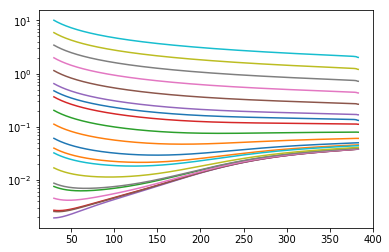

In [11]:
for i in range(len(freqs)):
    semilogy(ells[30:], input_model[i][30:])

# generate some data with the same input parameters

In [12]:
data = ff.ps_data_fg(ells, freqs, params_fg) + cmb(ells, 0.01)

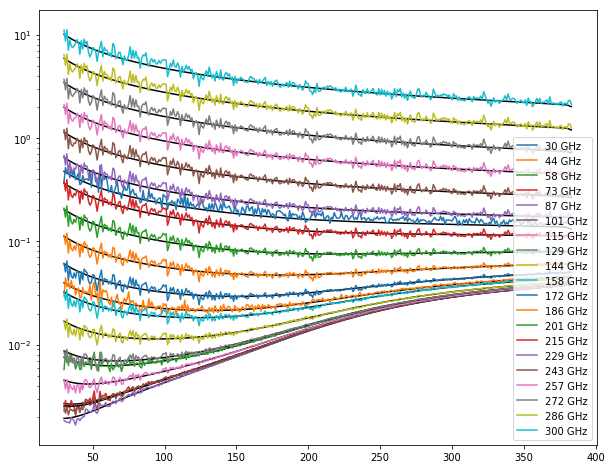

In [15]:
figure(figsize(10,8))
for i in range(len(freqs)):
    semilogy(ells[30:], input_model[i][30:], 'k')
    semilogy(ells[30:], data[i][30:], label='{:.0f} GHz'.format(freqs[i]*1e-9))
    legend(loc='lower right')

# good, so data is working and matches the input model

# now want to minimize

In [16]:
initial_s = [1.e-7, -3., -2.5, -4.]
initial_d = [1.e-7, -3., 2.,   -2.5]
initial_r = [1.e-1]
initial_cmb = initial_s + initial_d + initial_r

L-BFGS-B runs and outputs, but it doesn't move the spectral indices. Adding more frequencies (up to 50) doesn't seem to have helped.

These nores are based on the initial positions

```initial_s = [1.e-5, -3., -2.5, -4.]
initial_d = [1.e-9, -3., 2.,   -2.5]
initial_r = [1.e-1]
initial_cmb = initial_s + initial_d + initial_r```

Methods
* `Nelder-Mead`:
    - cannot handle bounds.
    - did move, runs for long time (~4 mins) and requires `options={'maxiter':, 'maxfev':}` (default set to 200*number of variables)
    - ran, claimed it converged, but output was nonsense
* `Powell`: 
    - cannot handle bounds
    - worked with synch+dust+cmb in 0x0 only
    - errors `RuntimeWarning: invalid value encountered in double_scalars std = a * (-gamma)**b * np.exp(c*gamma)`
    - errors `RuntimeWarning: invalid value encountered in multiply moment0x0[i] = pcls * sed_scaling[i]**2`
    - errors `RuntimeWarning: invalid value encountered in multiply moment0x2[i] = np.log(freqs[i]/nu0)**2 * sed_scaling[i]**2 * pcls * sum`
    - ran for > 10 minutes without exiting, force interrupted.
* `CG`:
    - ran in ~2 mins
    - 900% error in r, and O(20%) errors in other parameters.
    - `Desired error not necessarily achieved due to precision loss.`
* `BFGS`:
    - very angry, lots of error messages: `invalid value encountered in double_scalars`, `invalid value encountered in true_divide`, `overflow encountered in double_scalars`, `overflow encountered in multiply`
    - chi2 returned nan, parameters are dreadful
* `Newton-CG`:
    - requires jacobian
* `TNC`:
    - can work with bounds. Unbounded it produces garbage, but runs quickly ~25 sec
    - with weakest bounds $(\gamma_c < -2.01)$ get same garbage result
* `L-BFGS-B`:
    - can do bounds
    - worked with full fits with synch only
    - errors and garbage result
    - ~70 sec to run
* `COBYLA`:
    - ran for >10 minutes. No error messages, but never exited. Forced interrupt
* `SLSQP`:
* `trust-constr`
* `dogleg`:
* `trust-ncg`:
* `trust-exact`:
* `trust-krylov`:

should possibly try starting closer to the correct ampltidues. Try starting with 

```initial_s = [1.e-7, -3., -2.5, -4.]
initial_d = [1.e-7, -3., 2.,   -2.5]
initial_r = [1.e-1]
initial_cmb = initial_s + initial_d + initial_r```

Methods
* `Nelder-Mead`:
    - 3.5 minutes, output still bad, but closer. It does move the indices at least, just not well
* `Powell`:
    - still runs forever without outputting
* `L-BFGS-B`:
    - Moved the things, but not working
    - `b'ABNORMAL_TERMINATION_IN_LNSRCH'`

In [28]:
start=time.time()
soln = minimize(chi2_cmb, initial_cmb, args=(ells, freqs, input_cosmic_var, data), method='L-BFGS-B',
               bounds=((None,None), (None,None), (None,None), (None,-2.01),
                      (None,None), (None,None), (None,None), (None,-2.01),
                      (None,None)))
print(soln)
end=time.time()
print(end-start)

      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.56590236e+07, -4.49550229e+04,  4.32572582e+04, -3.28941678e+02,
        1.10911936e+09, -6.01912783e+04,  2.10228289e+04, -1.62109936e+04,
       -3.04898786e+03])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 690
      nit: 12
   status: 2
  success: False
        x: array([ 8.11499585e-07, -2.99882360e+00, -2.50207695e+00, -3.99998377e+00,
        2.93329185e-07, -2.99804069e+00,  2.00123319e+00, -2.49772834e+00,
        8.84061272e-03])
62.18088173866272


In [32]:
print(chi2_cmb(soln.x, ells, freqs, input_cosmic_var, data), chi2_cmb(params_in, ells, freqs, input_cosmic_var, data))

55568.401648747145 4560.154776578422


In [33]:
x = soln.x
in_x = params_fg + [0.01]
fit = ff.model_fg(ells, freqs, x[:-1]) + cmb(ells,x[-1])
errors = (x-in_x)/in_x*100
print('Error in amps: {0:.1f}%, {1:.1f}%'.format(errors[0], errors[4]))
print('Error in alphas: {0:.1f}%, {1:.1f}%'.format(errors[1], errors[5]))
print('Error in betas: {0:.1f}%, {1:.1f}%'.format(errors[2], errors[6]))
print('Error in gammas: {0:.1f}%, {1:.1f}%'.format(errors[3], errors[7]))
print('Error in r: {0:.1f}%'.format(errors[8]))

Error in amps: 259.5%, -53.7%
Error in alphas: 15.3%, 15.3%
Error in betas: -19.3%, 25.1%
Error in gammas: 53.8%, -16.7%
Error in r: -11.6%


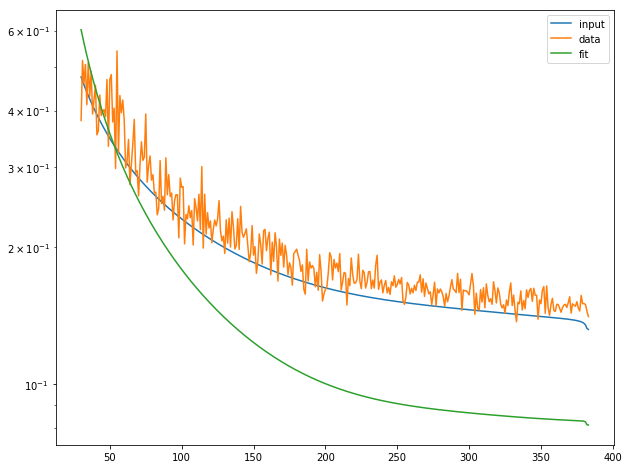

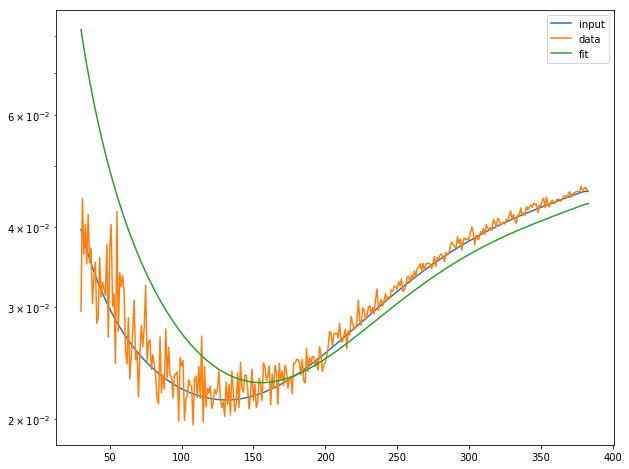

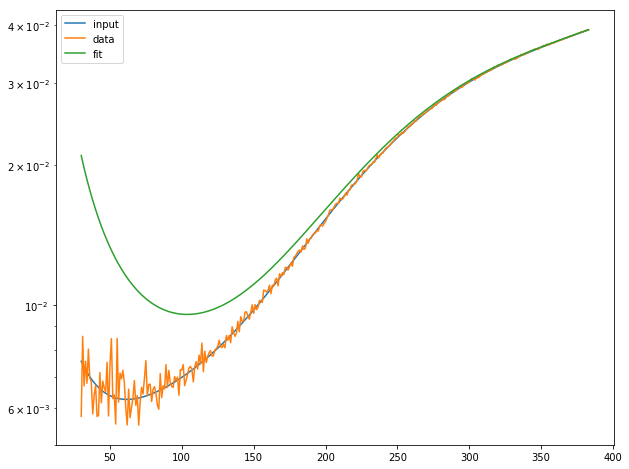

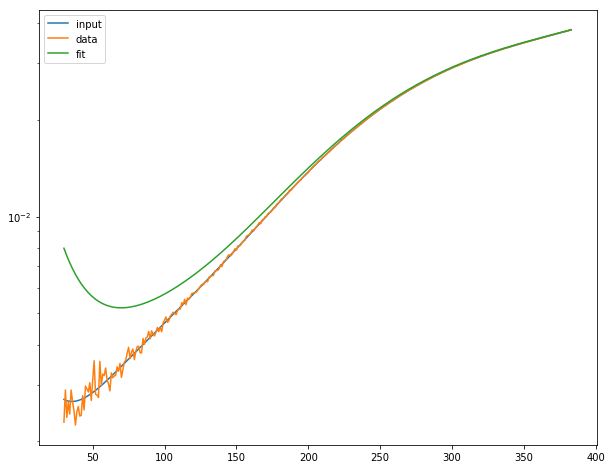

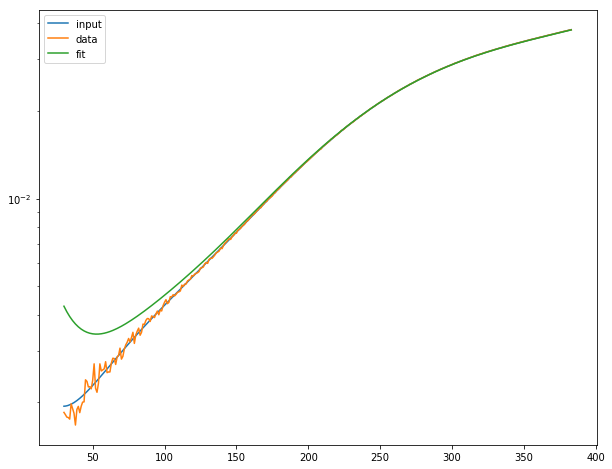

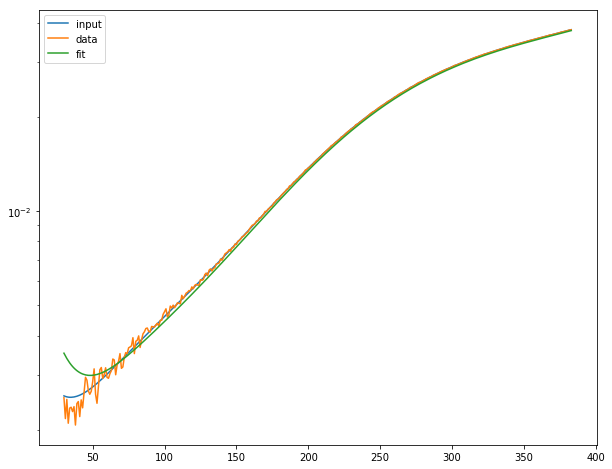

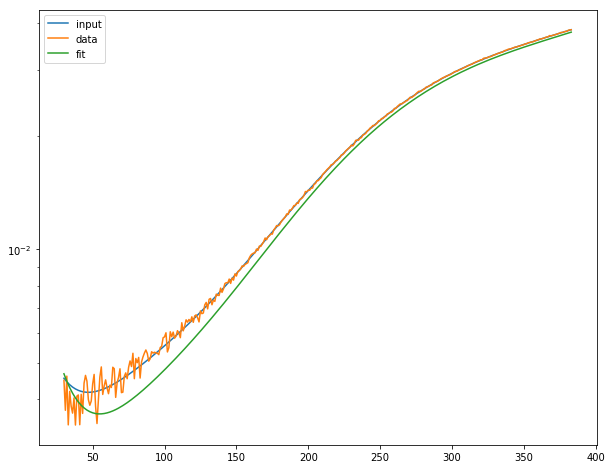

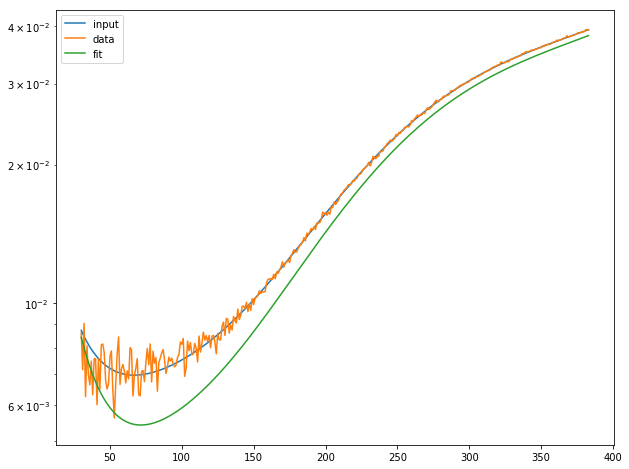

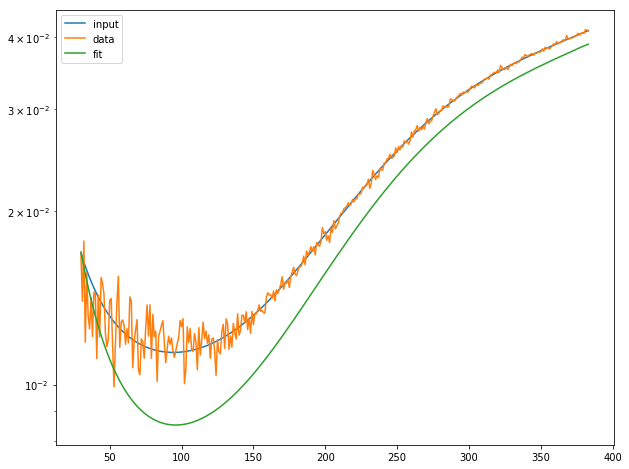

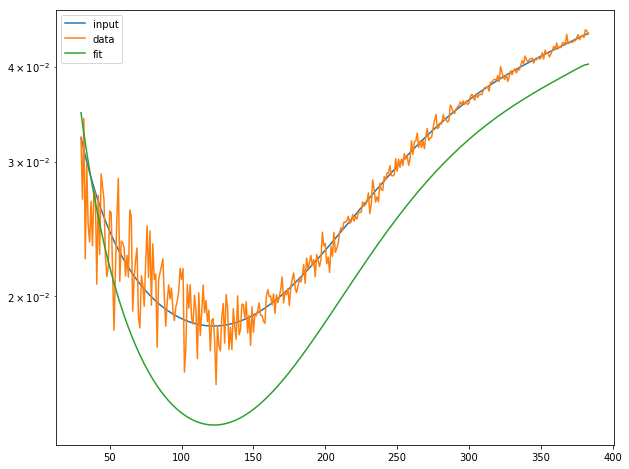

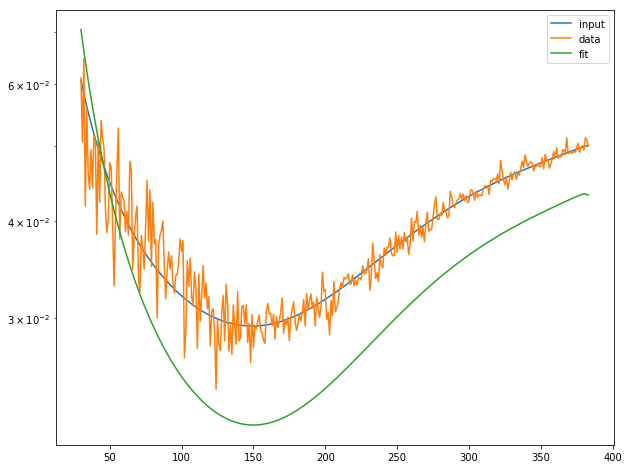

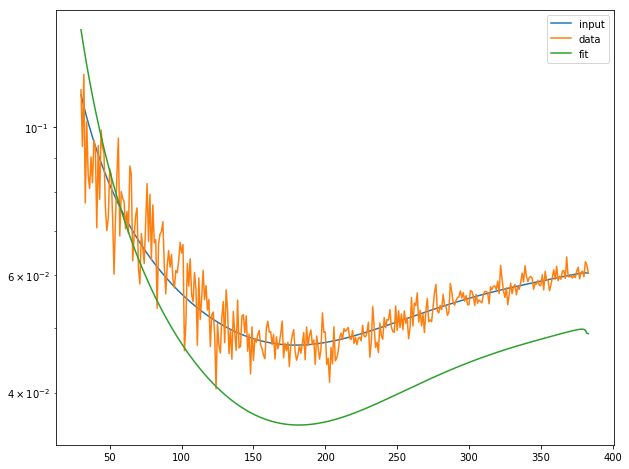

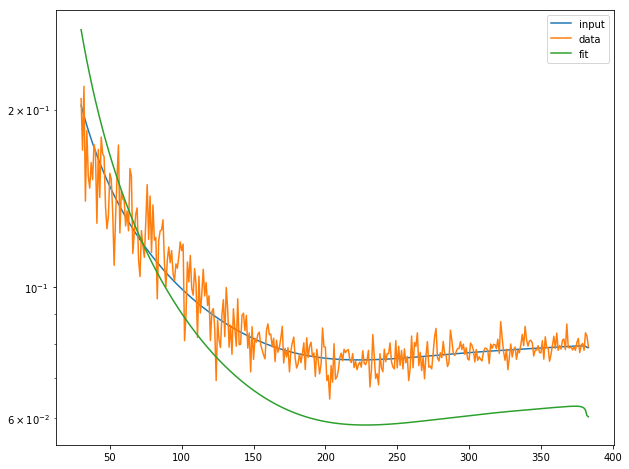

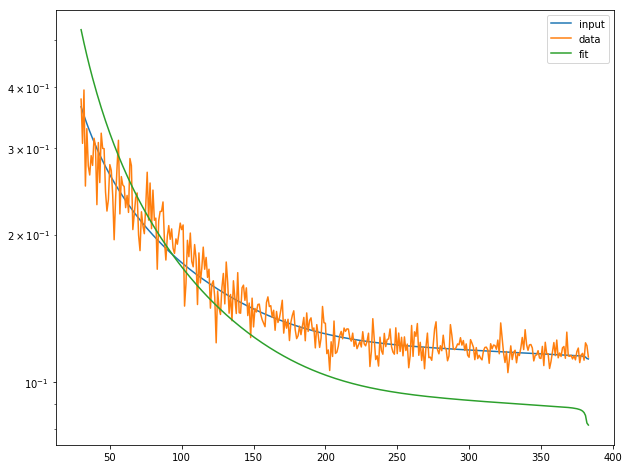

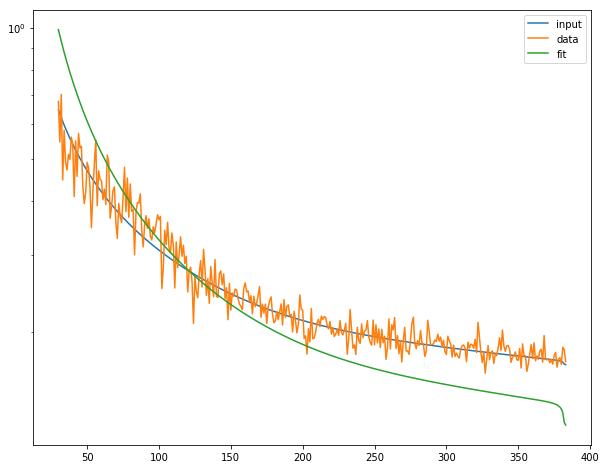

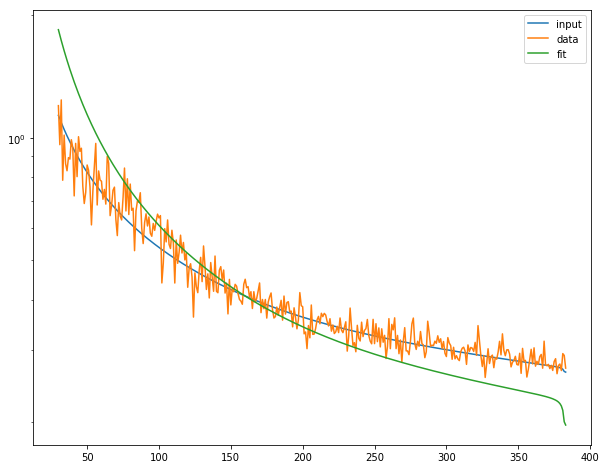

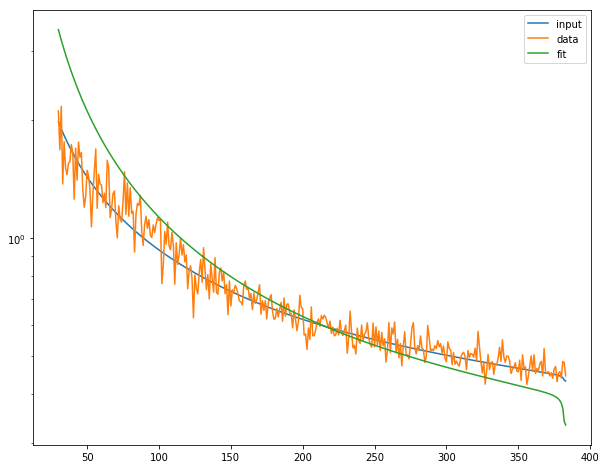

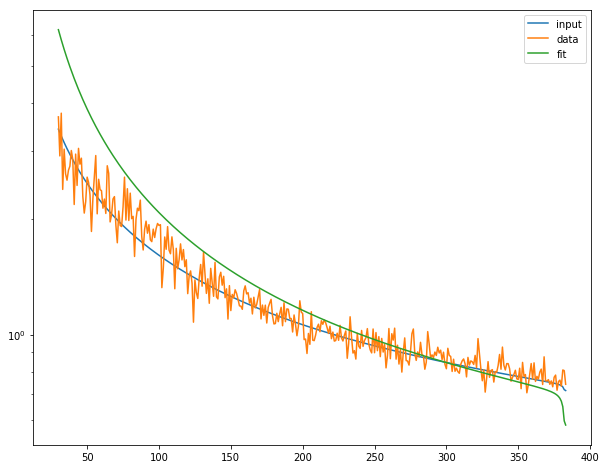

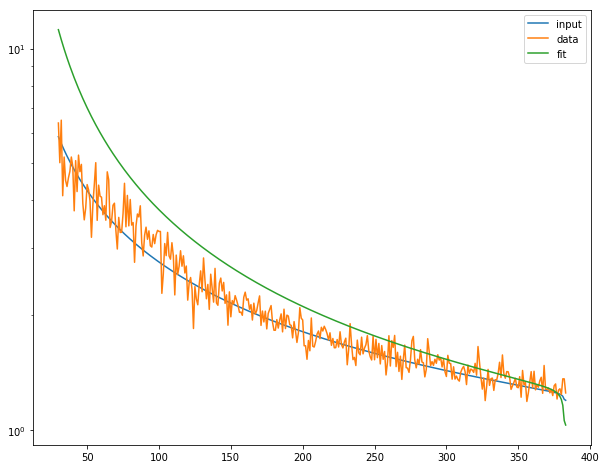

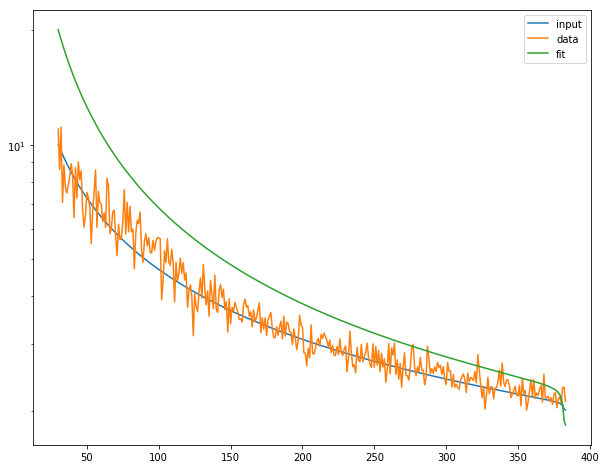

In [34]:
for i in range(len(freqs)):
    figure()
    semilogy(ells[30:], input_model[i][30:], label='input')
    semilogy(ells[30:], data[i][30:], label='data')
    semilogy(ells[30:], fit[i][30:], label='fit')
    legend()

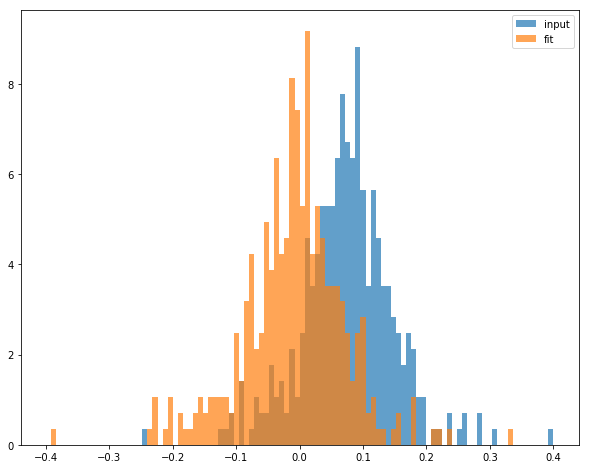

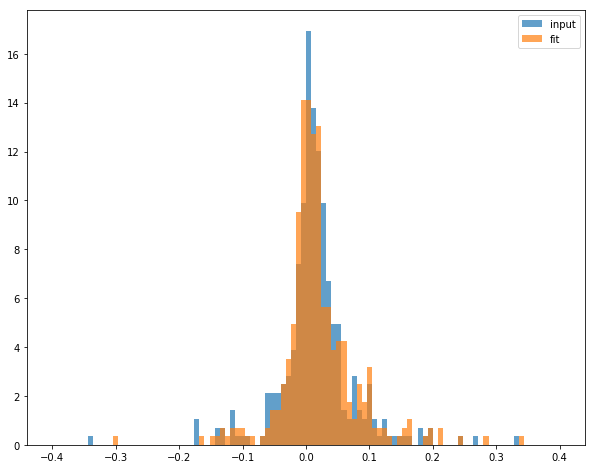

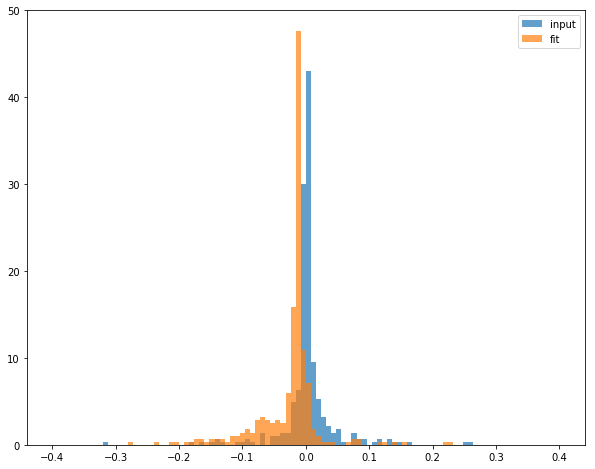

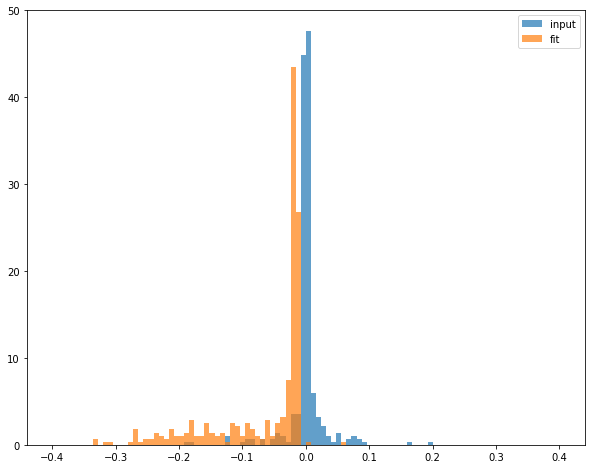

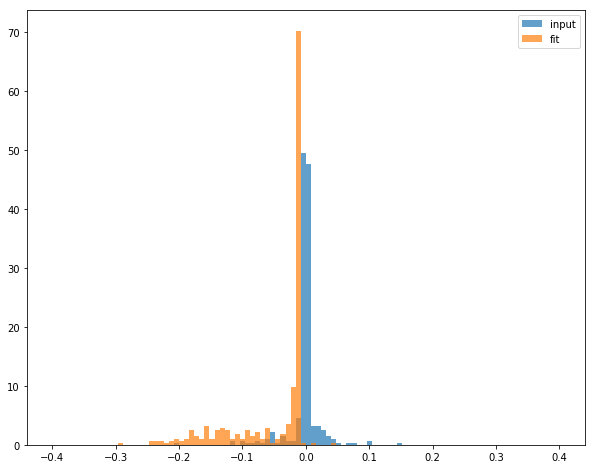

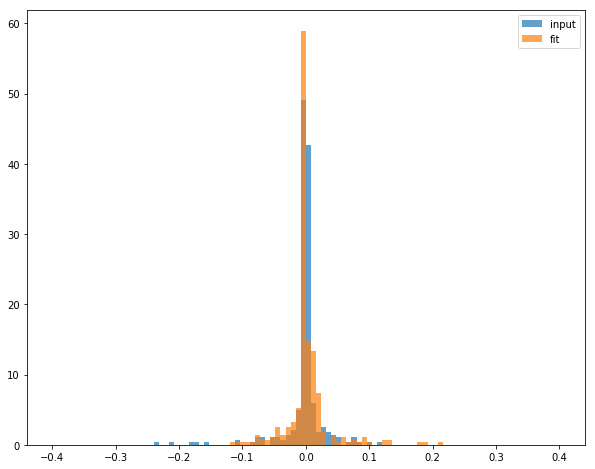

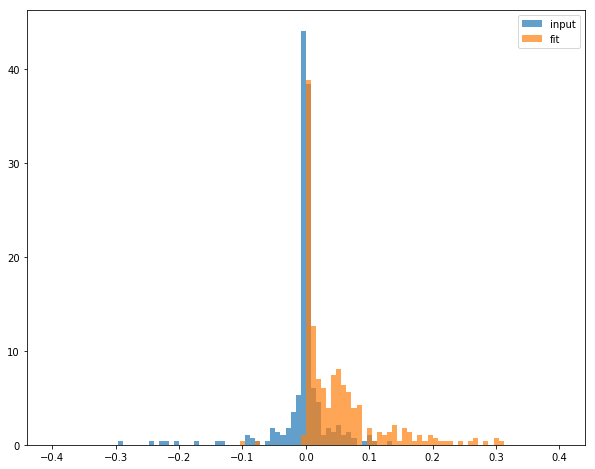

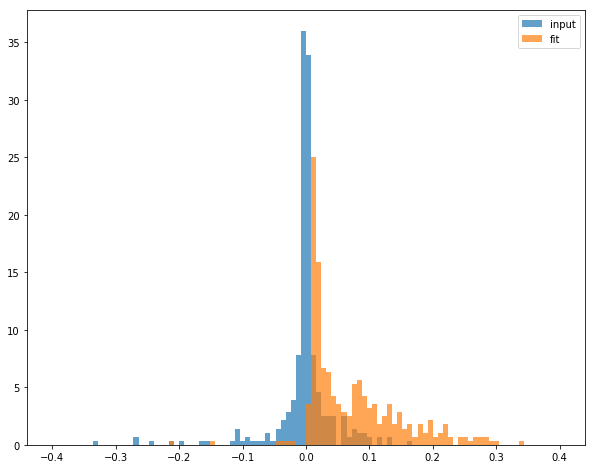

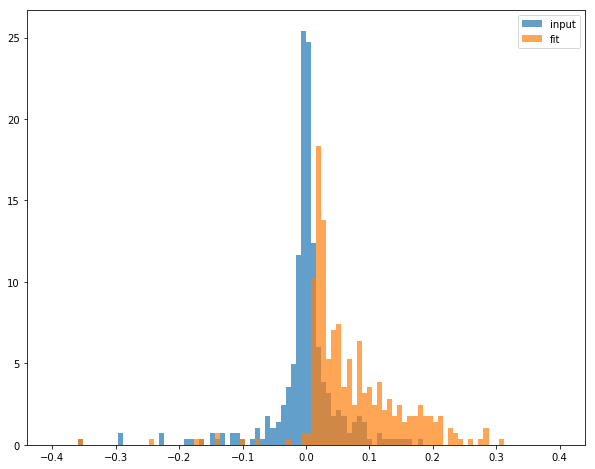

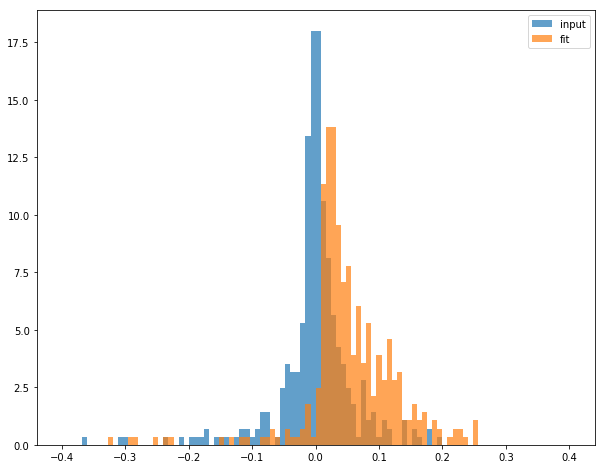

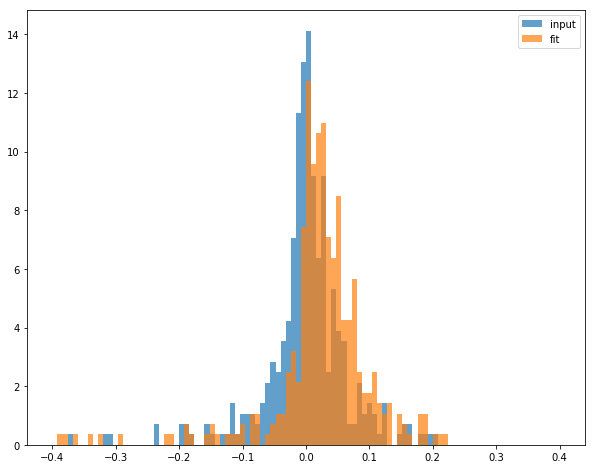

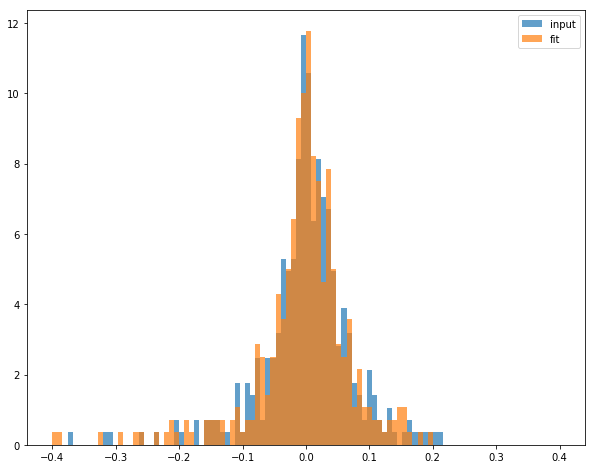

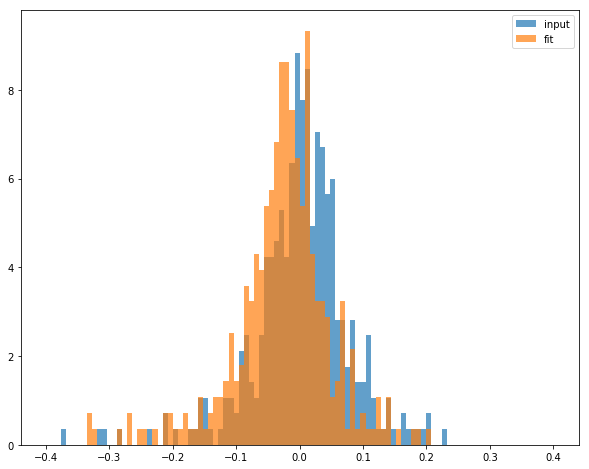

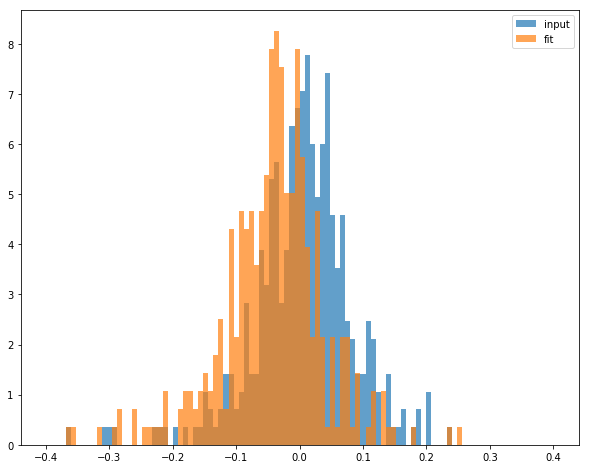

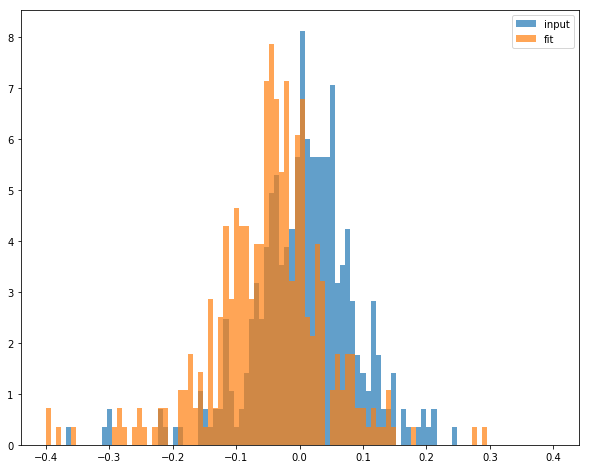

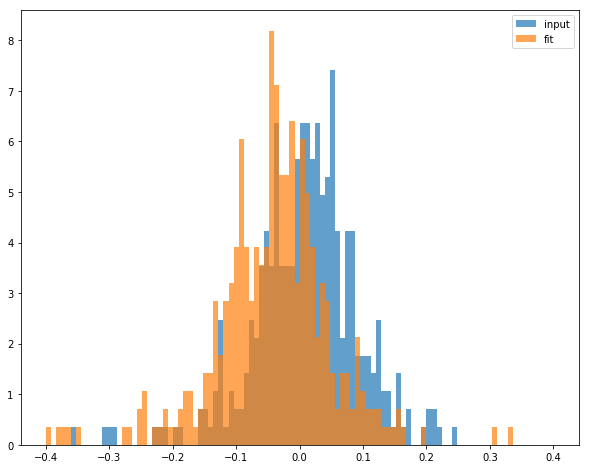

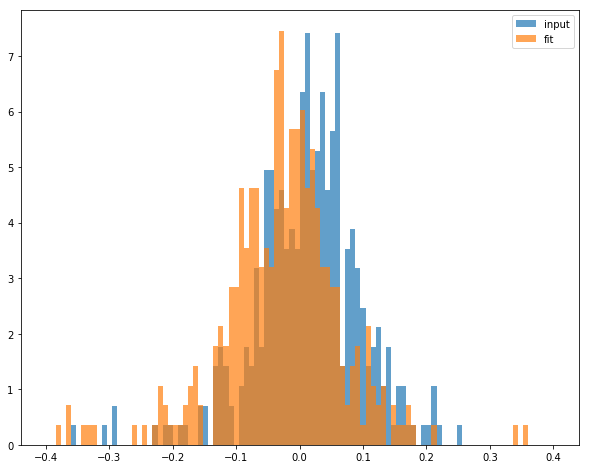

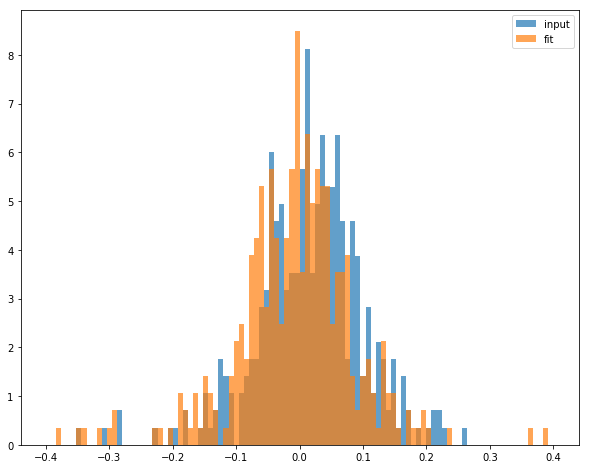

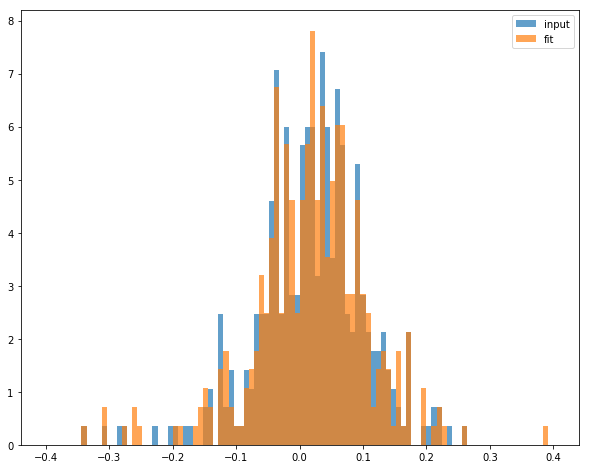

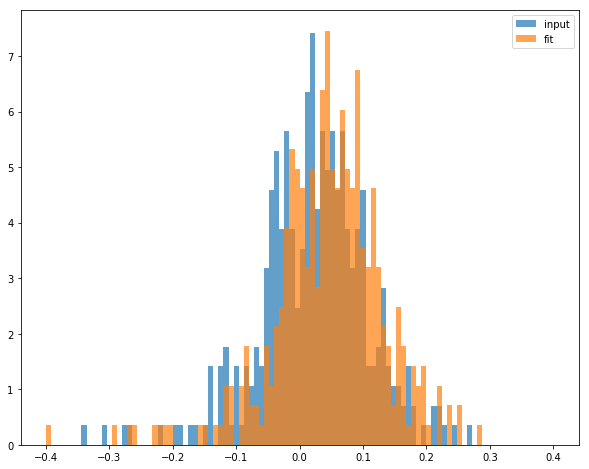

In [26]:
for i in range(len(freqs)):
    figure()
    hist((data[i][30:]-input_model[i][30:])/data[i][30:], label='input', alpha=0.7, bins=100, range=(-.4,.4), density=True)
    hist((data[i][30:]-fit[i][30:])/data[i][30:], label='fit', alpha=0.7, bins=100, range=(-.4,.4), density=True)

    legend()